<div style="
    border: 2px solid #333;
    background: #f9f9f9;
    padding: 16px 24px;
    margin: 20px 0;
    border-radius: 8px;
    font-family: sans-serif;
    overflow: hidden;
">
<div style="float: right; font-size: 12px; color: #555; text-align: right;">
    **Author:** Vince Mbanze<br>
    **Date:** July 2025
</div>
<h1 style="margin:0; color:#333; text-align:center; border-bottom: 2px solid #ccc; padding-bottom: 12px;">
    🐂 Bulls, Banks & Bollinger 📈<br>
    <span style="font-size: 0.7em; color: #666;">Quantitative Analysis of South African Bank Stocks</span>
</h1>
<p style="margin:16px 0 0 0; text-align: justify;">
    Welcome to this **streamlined quantitative analysis** of major JSE bank stocks.
    This notebook explores historical data, delves into return distributions and risk metrics,
    and rigorously backtests classical technical strategies—Moving Average Crossover and Bollinger Bands.
    We'll walk through each step with **clear visualizations and concise interpretations**,
    culminating in a performance comparison that includes the crucial impact of transaction costs.
</p>
</div>

### Notebook Overview

1.  **Data Acquisition & Cleaning**
2.  **Exploratory Data Analysis: Statistical Insights** 
3.  **EDA: Visualizing Returns & Correlations** 
4.  **Trading Strategy Definitions** 
5.  **Strategy Backtesting & Visualizations**
6.  **Final Performance Summaries** 

<div style="
    border-left: 4px solid #009688;
    background: #e0f1f1;
    padding: 16px;
    margin: 20px 0;
    border-radius: 6px;
">
  <h3 style="margin:0; color:#009688;">⚙️ 1. Initial Setup & Global Parameters</h3>
  <p style="margin:12px 0 0 0; text-align: justify;">
    This section initializes all necessary Python libraries for data manipulation, analysis, and visualization.
    Crucially, it defines all **global parameters** at the outset, including data fetching dates, stock tickers,
    data cleaning thresholds, and key parameters for trading strategies and risk calculations.
    Centralizing these parameters ensures easy modification and consistency throughout the analysis.
  </p>
</div>

In [3]:
# %% [code]
import scanpy as sc
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import jarque_bera # For normality tests
import datetime
import warnings

# Optional: Suppress warnings for a cleaner notebook output
warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.dpi': 80, 'figure.facecolor': 'white'})

# Set plotting aesthetics using matplotlib directly to bypass the bug
plt.rcParams.update({'figure.dpi': 80, 'figure.facecolor': 'white'})

sc.logging.print_header()

Package,Version
pandas,2.3.1
numpy,1.26.4
yfinance,0.2.65
matplotlib,3.10.0
seaborn,0.13.2
scipy,1.15.3
scanpy,1.11.2
Component,Info
Python,"3.11.8 | packaged by Anaconda, Inc. | (main, Feb 26 2024, 21:34:05) [MSC v.1916 64 bit (AMD64)]"
OS,Windows-10-10.0.26100-SP0


In [1]:
# Set consistent plotting styles for a professional and cohesive visual appeal
plt.style.use('seaborn-v0_8-darkgrid') # A clean, modern grid style
sns.set_palette('viridis') # A sequential color palette that works well

# --- Global Parameters ---
# Define the date range for fetching historical stock data
START_DATE = '2015-07-24'
END_DATE = '2025-07-24' # Set to current date to fetch the latest available data

# List of JSE bank stock ticker symbols (as used by Yahoo Finance)
TICKERS = ['SBK.JO', 'FSR.JO', 'NED.JO', 'ABG.JO', 'CPI.JO']
# Mapping for displaying human-readable names in outputs and plots
TICKER_NAMES = {
    'SBK.JO': 'Standard Bank',
    'FSR.JO': 'FirstRand',
    'NED.JO': 'Nedbank',
    'ABG.JO': 'Absa Group',
    'CPI.JO': 'Capitec'
}

# Data Cleaning Parameter: Threshold for identifying and filtering extreme daily returns
# Returns with an absolute value greater than this threshold will be treated as outliers.
MAX_DAILY_RETURN_THRESHOLD = 0.20 # e.g., filters out single-day movements beyond +/- 20%

# Strategy Parameters: Window lengths for the Moving Average Crossover strategy
MA_SHORT_WINDOW = 7  # Shorter-term moving average
MA_LONG_WINDOW = 21  # Longer-term moving average

# Strategy Parameters: Window and standard deviation multiplier for Bollinger Bands strategy
BB_WINDOW = 20       # Rolling window for the moving average within Bollinger Bands
BB_NUM_STD_DEV = 2   # Number of standard deviations for the upper and lower bands

# Risk Metrics Parameters: Confidence level for Value at Risk (VaR) and the annual risk-free rate
VAR_CONFIDENCE_LEVEL = 0.05 # For a 95% VaR, we look at the 5th percentile of losses
RISK_FREE_RATE_ANNUAL = 0.07 # Example: 7% annual risk-free rate. Adjust to a more accurate current SA rate if available.

# Backtesting Parameter: Assumed transaction cost per round-trip trade (e.g., buying and then selling)
TRANSACTION_COST = 0.001 # 0.001 represents 0.1% transaction cost

<div style="
    border-left: 4px solid #009688;
    background: #e0f1f1;
    padding: 16px;
    margin: 20px 0;
    border-radius: 6px;
">
  <h3 style="margin:0; color:#009688;">🔬 2. Data Acquisition & Cleaning</h3>
  <p style="margin:12px 0 0 0; text-align: justify;">
    This crucial section handles the retrieval of historical stock data from Yahoo Finance.
    The `fetch_and_clean_data` function is defined here, encapsulating the entire process of:
    <br>• Downloading historical **Close prices** and **Volume** for the specified JSE bank stocks.
    <br>• Applying robust cleaning steps to manage missing values, zero/negative prices, and extreme daily return outliers.
    <br>• Renaming tickers to human-readable names for clarity.
    <br>Immediately following its definition, the function is executed, and a preview of the cleaned data is displayed for verification.
  </p>
</div>

In [ ]:
# %% [code]
def fetch_and_clean_data(tickers, start_date, end_date, max_daily_return_threshold, ticker_names):
    """
    Fetches historical stock data from Yahoo Finance and performs essential initial cleaning.

    Handles MultiIndex DataFrame output from yfinance.download() and cleans spurious data points.

    Args:
        tickers (list): List of ticker symbols.
        start_date (str): Start date for data download.
        end_date (str): End date for data download.
        max_daily_return_threshold (float): Max absolute daily return to filter outliers.
        ticker_names (dict): Mapping from ticker symbol to human-readable name.

    Returns:
        tuple: (pd.DataFrame: Cleaned Close prices, pd.DataFrame: Cleaned Volume data)
    """
    print(f"1.1 Downloading data for {len(tickers)} tickers from {start_date} to {end_date}...")
    data = yf.download(tickers, start=start_date, end=end_date)
    print("   Data download complete.")

    # CRITICAL: Use 'Close' price as 'Adj Close' might not always be available for all tickers/regions
    close_prices = data.xs('Close', level=0, axis=1).copy()
    volume = data.xs('Volume', level=0, axis=1).copy()

    # Rename columns for clarity in analysis
    close_prices.rename(columns=ticker_names, inplace=True)
    volume.rename(columns=ticker_names, inplace=True)

    print("1.2 Performing initial data cleaning (handling NaNs, zeros, outliers)...")
    # Handle NaNs: forward-fill then backward-fill
    close_prices = close_prices.ffill().bfill()
    volume = volume.ffill().bfill()

    # Filter out spurious zero or negative prices
    close_prices = close_prices.replace(0, np.nan).dropna(how='all')
    close_prices = close_prices[close_prices > 0].ffill().bfill()

    # Identify and filter extreme daily returns (potential data errors)
    daily_returns = close_prices.pct_change()
    for col in daily_returns.columns:
        outlier_mask = daily_returns[col].abs() > max_daily_return_threshold
        if outlier_mask.any():
            print(f"   > Filtered {outlier_mask.sum()} extreme return(s) for {col}.")
            daily_returns.loc[outlier_mask, col] = np.nan
            close_prices.loc[outlier_mask, col] = np.nan
            close_prices[col] = close_prices[col].ffill().bfill()

    print("1.3 Data cleaning complete and data is ready for analysis.")
    return close_prices, volume


# --- EXECUTION: Data Acquisition & Cleaning ---
print("--- Section 1: Data Acquisition & Cleaning ---")
close_prices, volumes = fetch_and_clean_data(TICKERS, START_DATE, END_DATE, MAX_DAILY_RETURN_THRESHOLD, TICKER_NAMES)

print("\n--- Verification: Cleaned Close Prices (Head & Tail) ---")
print("First 5 rows:\n", close_prices.head().to_markdown(numalign="left", stralign="left"))
print("\nLast 5 rows:\n", close_prices.tail().to_markdown(numalign="left", stralign="left"))

print(f"\nData available from {close_prices.index.min().date()} to {close_prices.index.max().date()}.")
print(f"Total number of trading days: {len(close_prices)}.")
print("--- Section 1 Complete ---\n")

<div style="
    border-left: 4px solid #009688;
    background: #e0f1f1;
    padding: 16px;
    margin: 20px 0;
    border-radius: 6px;
">
  <h3 style="margin:0; color:#009688;">🔬 2. Exploratory Data Analysis: Statistical Insights</h3>
  <p style="margin:12px 0 0 0; text-align: justify;">
    This section dives into the **statistical characteristics of daily stock returns**.
    We define a reusable function, <code>analyze_returns</code>, to compute essential metrics such as mean, standard deviation, skewness, and kurtosis.
    Crucially, it also performs the **Jarque-Bera normality test** to assess how closely the return distributions resemble a normal distribution.
    Furthermore, it calculates the **correlation matrix** between the bank stocks and key **risk metrics** (Value at Risk - VaR, Conditional VaR - CVaR, and Sharpe Ratios), providing a quantitative foundation for understanding stock behavior.
  </p>
</div>

In [5]:
# %% [code]
def analyze_returns(prices, var_confidence_level, risk_free_rate_annual):
    """
    Calculates daily returns, various descriptive statistics, correlation matrix,
    Value at Risk (VaR), Conditional VaR (CVaR), and Sharpe Ratio.

    Args:
        prices (pd.DataFrame): DataFrame of historical prices (e.g., Close prices).
        var_confidence_level (float): The alpha level for VaR and CVaR (e.g., 0.05 for 95% confidence).
        risk_free_rate_annual (float): The annualized risk-free rate.

    Returns:
        tuple:
            - daily_returns_df (pd.DataFrame): DataFrame of daily percentage returns.
            - stats_df (pd.DataFrame): DataFrame containing descriptive statistics and normality test results.
            - correlation_matrix (pd.DataFrame): Correlation matrix of daily returns.
            - var_cvar_df (pd.DataFrame): DataFrame containing VaR, CVaR, and Sharpe Ratio.
    """
    print("2.1 Calculating Daily Returns & Descriptive Statistics...")
    daily_returns = prices.pct_change().dropna()
    
    # Calculate daily risk-free rate from annual rate (assuming 252 trading days)
    risk_free_rate_daily = (1 + risk_free_rate_annual)**(1/252) - 1

    # Descriptive Statistics: Mean, Std Dev, Skewness, Kurtosis, and Annualized versions
    stats = pd.DataFrame({
        'Mean Daily Return': daily_returns.mean(),
        'Std Dev Daily Return': daily_returns.std(),
        'Skewness': daily_returns.skew(),
        'Kurtosis': daily_returns.kurtosis(),
        'Annualized Mean Return (%)': daily_returns.mean() * 252 * 100,
        'Annualized Volatility (%)': daily_returns.std() * np.sqrt(252) * 100
    })

    # Jarque-Bera Test for Normality: Statistically checks if the distribution is normal
    jb_test_results = {}
    for col in daily_returns.columns:
        jb_test = jarque_bera(daily_returns[col].dropna())
        jb_test_results[col] = {
            'JB Statistic': jb_test[0],
            'JB p-value': jb_test[1],
            'Normality Rejected (p<0.05)': jb_test[1] < 0.05 # Reject if p-value is low
        }
    stats = stats.join(pd.DataFrame(jb_test_results).T)
    print("2.2 Descriptive statistics and normality tests calculated.")

    print("2.3 Calculating Correlation Matrix...")
    correlation_matrix = daily_returns.corr()
    print("2.4 Correlation matrix calculated.")

    print("2.5 Calculating Value at Risk (VaR), Conditional VaR (CVaR), and Sharpe Ratios...")
    # VaR: Max potential loss at a given confidence level
    # CVaR: Expected loss if VaR is breached (more conservative tail risk measure)
    var_cvar = pd.DataFrame(index=daily_returns.columns)
    var_cvar['VaR (95%)'] = daily_returns.quantile(var_confidence_level)
    for col in daily_returns.columns:
        var_cvar.loc[col, 'CVaR (95%)'] = daily_returns[col][daily_returns[col] < var_cvar.loc[col, 'VaR (95%)']].mean()

    # Sharpe Ratio: Risk-adjusted return (excess return per unit of volatility)
    excess_returns = daily_returns - risk_free_rate_daily
    sharpe_ratio = (excess_returns.mean() / daily_returns.std()) * np.sqrt(252)
    var_cvar['Sharpe Ratio (Annualized)'] = sharpe_ratio
    var_cvar.loc[daily_returns.std() == 0, 'Sharpe Ratio (Annualized)'] = np.nan # Handle zero volatility
    print("2.6 Risk metrics and Sharpe Ratios calculated.")

    return daily_returns, stats, correlation_matrix, var_cvar


# --- EXECUTION: Exploratory Data Analysis - Statistical Insights ---
print("--- Section 2: Exploratory Data Analysis (Statistical Insights) ---")
daily_returns_df, stats_df, correlation_matrix, var_cvar_df = analyze_returns(
    close_prices, VAR_CONFIDENCE_LEVEL, RISK_FREE_RATE_ANNUAL
)

print("\n--- Key Finding: Daily Returns Descriptive Statistics & Normality ---")
print(stats_df.to_markdown(numalign="left", stralign="left"))
print("\nInterpretation:")
print("- Skewness: Indicates asymmetry of returns (positive = long right tail, negative = long left tail).")
print("- Kurtosis: Measures 'tailedness'. Higher kurtosis means more frequent extreme returns (fat tails).")
print("- Jarque-Bera Test: A p-value < 0.05 typically means we reject the hypothesis that the data is normally distributed.")
print("--- Section 2 Complete ---\n")

--- Section 2: Exploratory Data Analysis (Statistical Insights) ---
2.1 Calculating Daily Returns & Descriptive Statistics...
2.2 Descriptive statistics and normality tests calculated.
2.3 Calculating Correlation Matrix...
2.4 Correlation matrix calculated.
2.5 Calculating Value at Risk (VaR), Conditional VaR (CVaR), and Sharpe Ratios...
2.6 Risk metrics and Sharpe Ratios calculated.

--- Key Finding: Daily Returns Descriptive Statistics & Normality ---
| Ticker        | Mean Daily Return   | Std Dev Daily Return   | Skewness   | Kurtosis   | Annualized Mean Return (%)   | Annualized Volatility (%)   | JB Statistic   | JB p-value   | Normality Rejected (p<0.05)   |
|:--------------|:--------------------|:-----------------------|:-----------|:-----------|:-----------------------------|:----------------------------|:---------------|:-------------|:------------------------------|
| Absa Group    | 0.000216428         | 0.0218918              | 0.00102188 | 7.02441    | 5.454              

<div style="
    border-left: 4px solid #009688;
    background: #e0f1f1;
    padding: 16px;
    margin: 20px 0;
    border-radius: 6px;
">
  <h3 style="margin:0; color:#009688;">📊 3. EDA: Visualizing Returns & Correlations</h3>
  <p style="margin:12px 0 0 0; text-align: justify;">
    Building on the statistical insights, this section focuses on the **visual interpretation of stock returns** and their interrelationships.
    It defines the <code>plot_return_distribution</code> function to generate histograms and QQ-plots, providing a visual confirmation of return distributions and normality.
    Subsequently, a **correlation heatmap** is generated to illustrate how the bank stocks move in tandem.
    Finally, key **risk metrics** (VaR, CVaR, and Sharpe Ratios) are presented in a consolidated table, offering a quantitative summary of risk-adjusted performance.
  </p>
</div>

--- Section 3: Exploratory Data Analysis (Visuals & Risk Metrics) ---
3.1 Generating visualizations for daily return distributions (histograms and QQ-plots)...


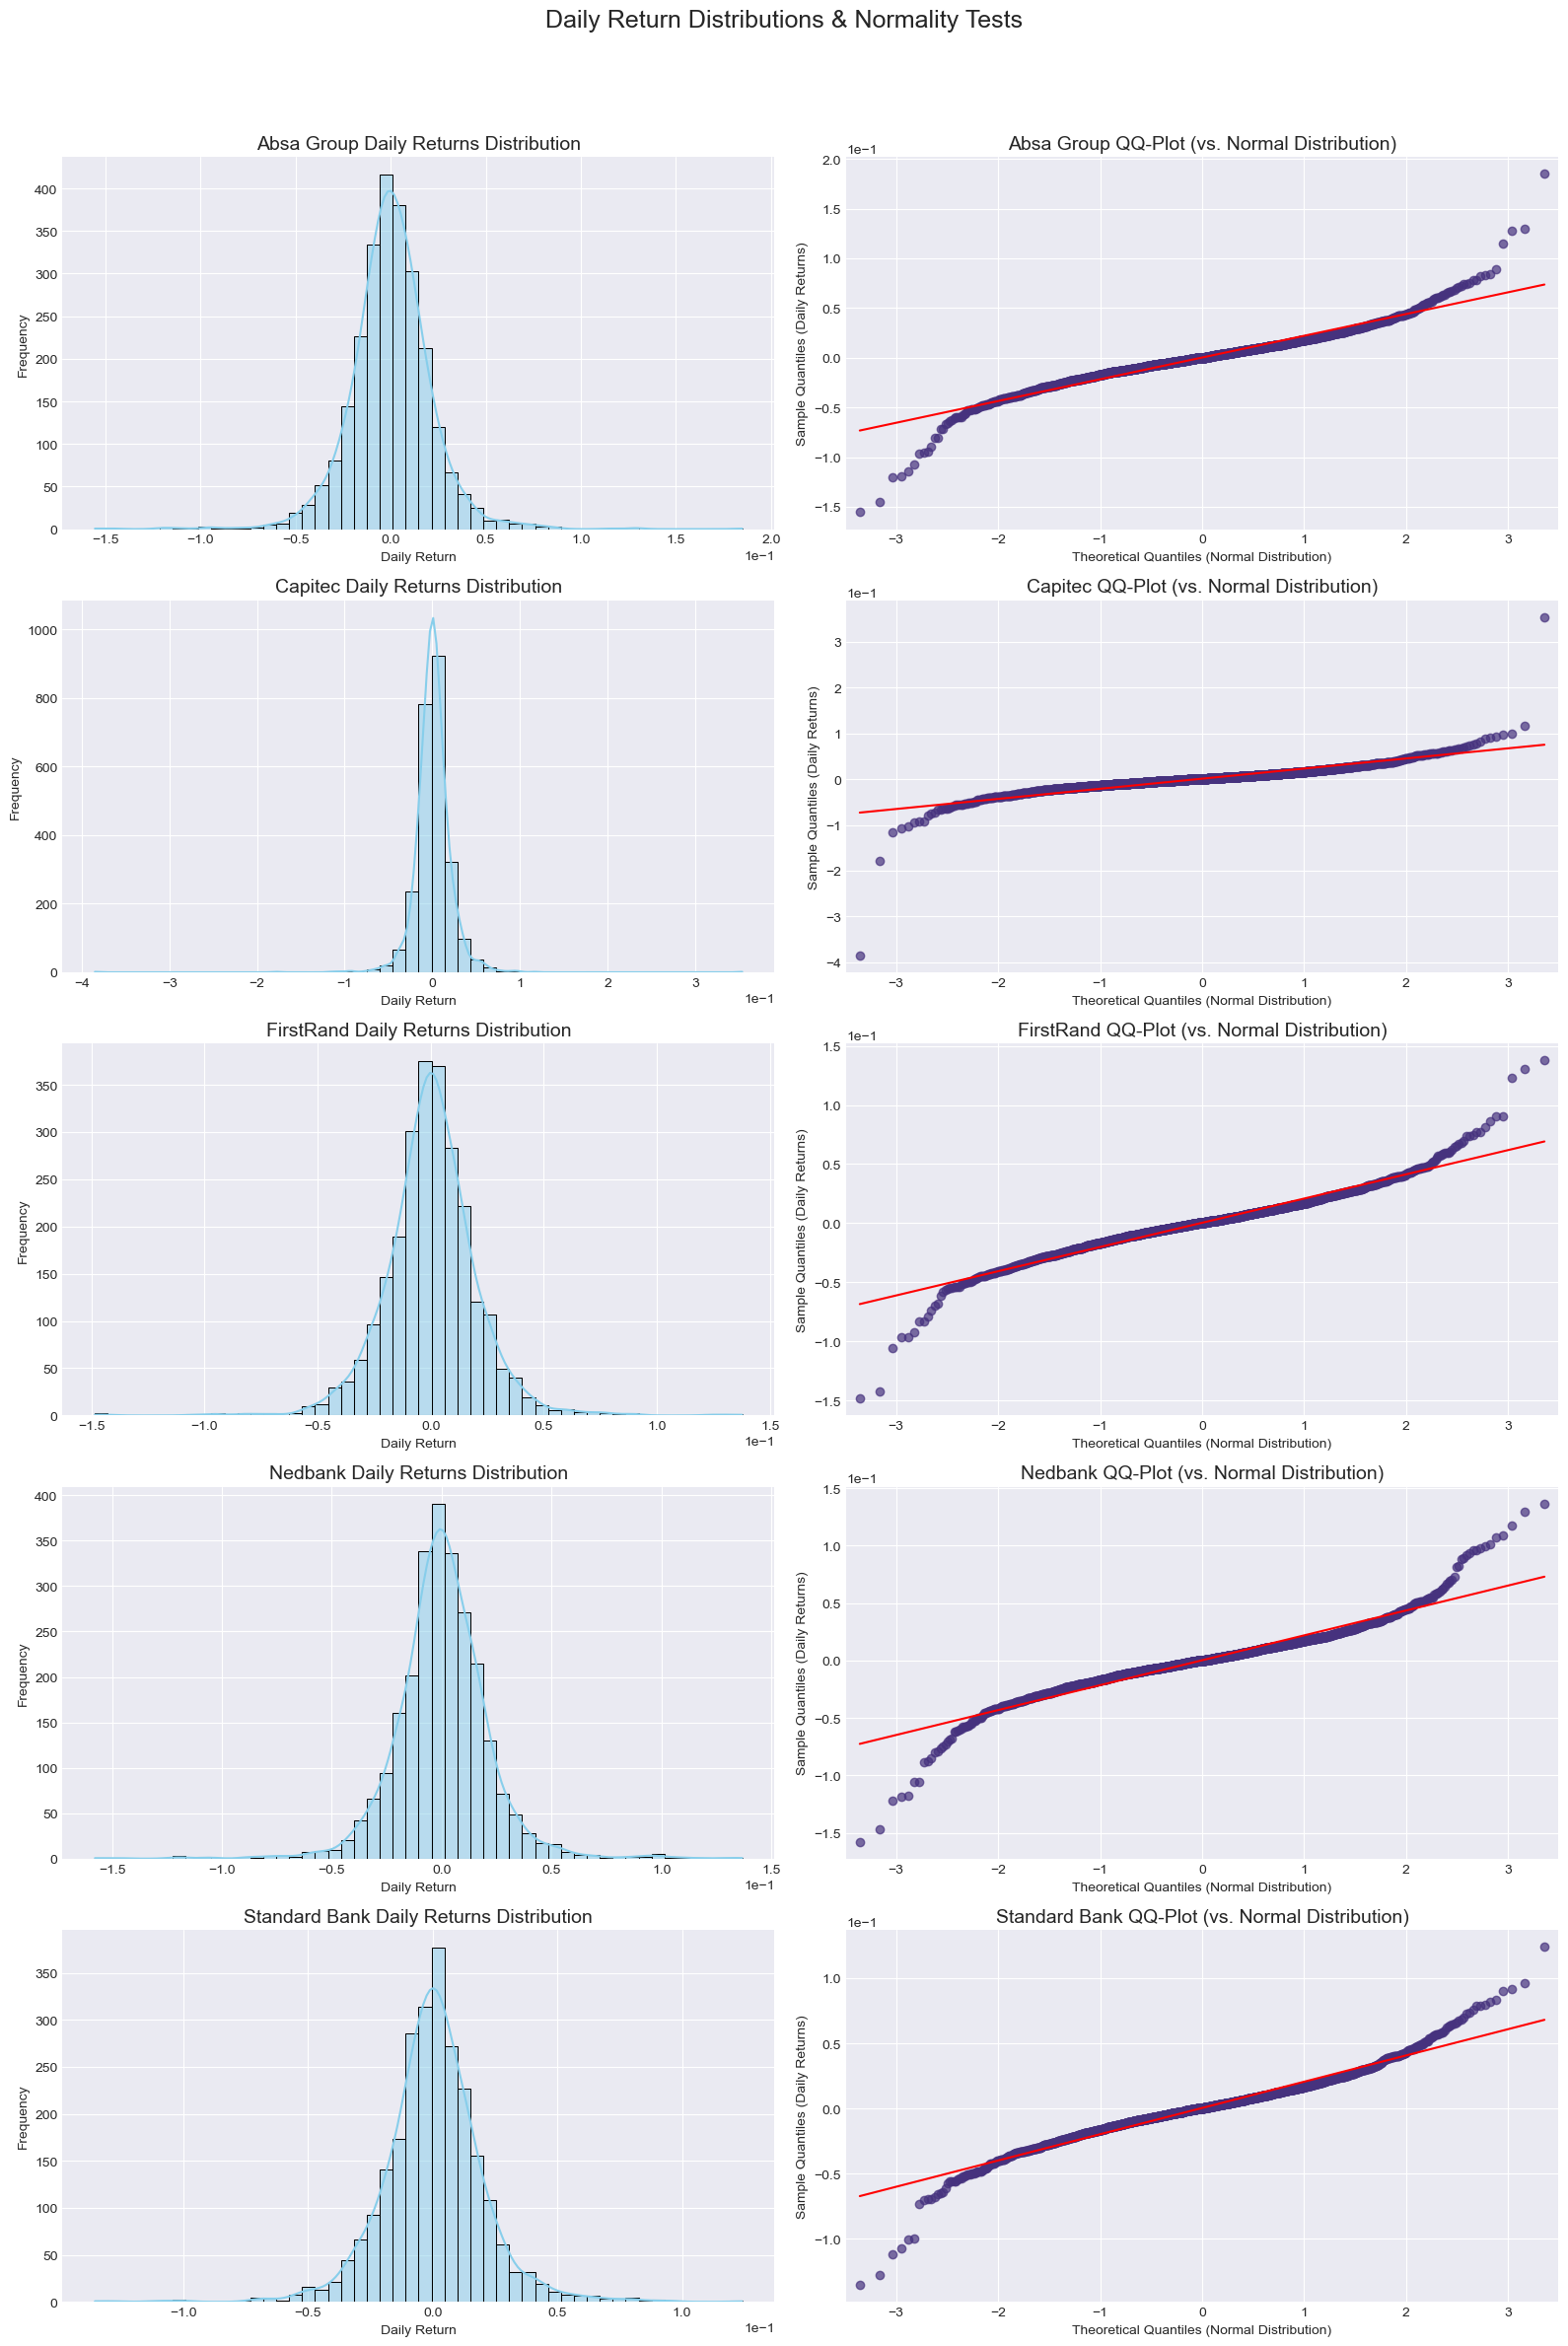

   Return distribution plots generated.

3.2 Generating Correlation Matrix Heatmap...


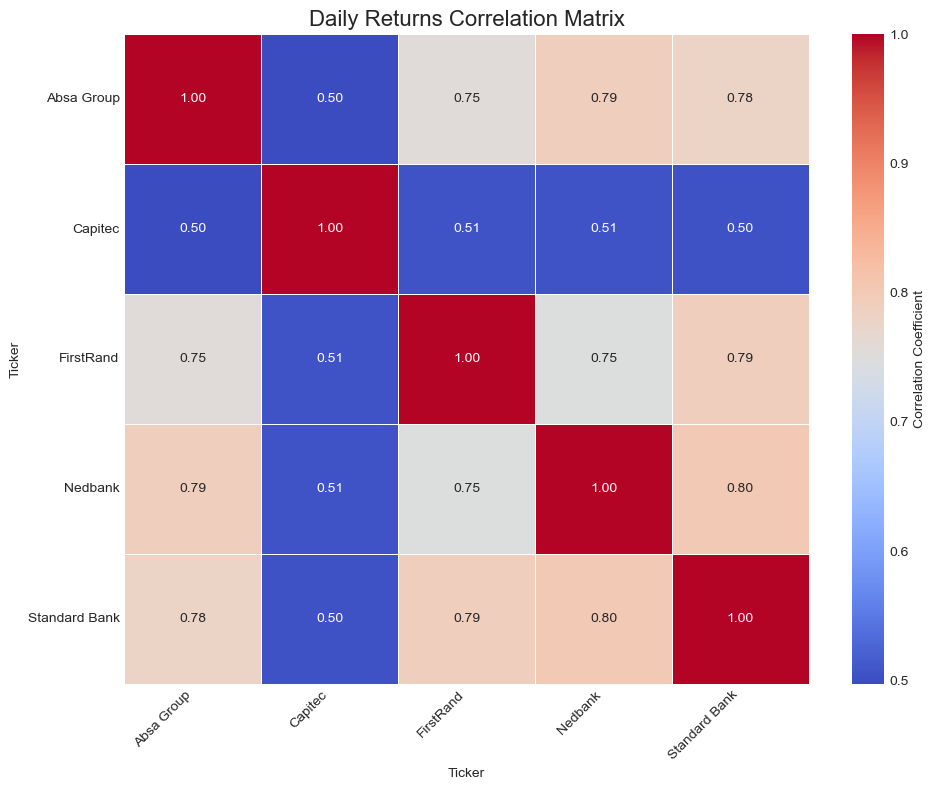

   Correlation matrix heatmap generated.
   Interpretation: Values closer to 1 (blue) indicate strong positive correlation; values closer to -1 (red) indicate strong negative correlation.

3.3 Key Risk Metrics: Value at Risk (VaR), Conditional VaR (CVaR), and Sharpe Ratios ---
| Ticker        | VaR (95%)   | CVaR (95%)   | Sharpe Ratio (Annualized)   |
|:--------------|:------------|:-------------|:----------------------------|
| Absa Group    | -0.0327883  | -0.0494928   | -0.0377754                  |
| Capitec       | -0.0275452  | -0.046757    | 0.569229                    |
| FirstRand     | -0.0310464  | -0.0455911   | 0.0509015                   |
| Nedbank       | -0.0313808  | -0.0488306   | -0.0335588                  |
| Standard Bank | -0.0308252  | -0.0451386   | 0.080535                    |

   Interpretation:
   - **VaR:** Maximum expected loss at a given confidence level (e.g., 95% VaR of -2.5% means 5% chance of losing 2.5% or more).
   - **CVaR:** Average loss when V

In [7]:
# %% [code]
def plot_return_distribution(daily_returns_df):
    """
    Plots histograms with KDE and QQ-plots against a normal distribution for daily returns of each stock.
    Visualizes the shape and tail behavior of return distributions.

    Args:
        daily_returns_df (pd.DataFrame): DataFrame of daily percentage returns for multiple stocks.
    """
    n_banks = len(daily_returns_df.columns)
    fig, axes = plt.subplots(n_banks, 2, figsize=(16, 5 * n_banks)) # One row per bank, two plots per row
    fig.suptitle('Daily Return Distributions & Normality Tests', fontsize=18, y=0.98)

    for i, col in enumerate(daily_returns_df.columns):
        # Histogram with KDE: Shows the frequency distribution of returns
        sns.histplot(daily_returns_df[col], kde=True, ax=axes[i, 0], bins=50, color='skyblue', edgecolor='black')
        axes[i, 0].set_title(f'{col} Daily Returns Distribution', fontsize=14)
        axes[i, 0].set_xlabel('Daily Return')
        axes[i, 0].set_ylabel('Frequency')
        # Format x-axis labels to scientific notation for clarity with small return values
        axes[i, 0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

        # QQ-plot (Quantile-Quantile Plot): Compares data distribution to a normal distribution
        # If points align with the 's' line, the data is approximately normal.
        import statsmodels.api as sm # statsmodels is required for qqplot
        sm.qqplot(daily_returns_df[col].dropna(), line='s', ax=axes[i, 1], color='purple', alpha=0.7)
        axes[i, 1].set_title(f'{col} QQ-Plot (vs. Normal Distribution)', fontsize=14)
        axes[i, 1].set_xlabel('Theoretical Quantiles (Normal Distribution)')
        axes[i, 1].set_ylabel('Sample Quantiles (Daily Returns)')
        # Consistent formatting for QQ-plot axes
        axes[i, 1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        axes[i, 1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlaps, especially with suptitle
    plt.show()


# --- EXECUTION: EDA - Visualizing Returns & Correlations ---
print("--- Section 3: Exploratory Data Analysis (Visuals & Risk Metrics) ---")

# 3.1 Visualize Return Distributions
print("3.1 Generating visualizations for daily return distributions (histograms and QQ-plots)...")
plot_return_distribution(daily_returns_df)
print("   Return distribution plots generated.")

# 3.2 Visualize Correlation Matrix
print("\n3.2 Generating Correlation Matrix Heatmap...")
plt.figure(figsize=(10, 8)) # Set a good size for the heatmap
sns.heatmap(
    correlation_matrix, # The correlation matrix from analyze_returns
    annot=True,         # Display the correlation values on the heatmap
    cmap='coolwarm',    # Color map: blue for positive, red for negative correlations
    fmt=".2f",          # Format annotation values to two decimal places
    linewidths=.5,      # Add lines to separate cells visually
    cbar_kws={'label': 'Correlation Coefficient'} # Label for the color bar
)
plt.title('Daily Returns Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10) # Rotate x-axis labels for readability
plt.yticks(rotation=0, fontsize=10)             # Ensure y-axis labels are horizontal
plt.tight_layout() # Adjust layout
plt.show()
print("   Correlation matrix heatmap generated.")
print("   Interpretation: Values closer to 1 (blue) indicate strong positive correlation; values closer to -1 (red) indicate strong negative correlation.")

# 3.3 Present VaR, CVaR, and Sharpe Ratios
print("\n3.3 Key Risk Metrics: Value at Risk (VaR), Conditional VaR (CVaR), and Sharpe Ratios ---")
print(var_cvar_df.to_markdown(numalign="left", stralign="left"))
print("\n   Interpretation:")
print("   - **VaR:** Maximum expected loss at a given confidence level (e.g., 95% VaR of -2.5% means 5% chance of losing 2.5% or more).")
print("   - **CVaR:** Average loss when VaR is breached (more conservative measure of tail risk).")
print("   - **Sharpe Ratio:** Measures risk-adjusted return; higher is better. Accounts for excess return over a risk-free rate.")
print("--- Section 3 Complete ---\n")

<div style="
    border-left: 4px solid #4CAF50;
    background: #e8f5e9;
    padding: 16px;
    margin: 20px 0;
    border-radius: 6px;
">
  <h3 style="margin:0; color:#4CAF50;">📈 Results: Visual EDA & Risk Profiles</h3>
  <p style="margin:12px 0 0 0; text-align: justify;">
    The visual and quantitative results from this section provide critical insights into the bank stocks:<br><br>
    <ul>
        <li><b>Return Distributions:</b> The histograms visually confirm the heavy tails, especially for Capitec, as indicated by the high kurtosis. The QQ-plots show clear deviations from the normal distribution line for all banks, reinforcing the Jarque-Bera test's conclusion that returns are not normally distributed.</li>
        <li><b>Correlation Matrix:</b> All bank stocks exhibit positive correlations, indicating they generally move in the same direction. Standard Bank and Nedbank, along with FirstRand and Nedbank, show particularly strong positive correlations. Capitec consistently displays lower correlations with the other banks, suggesting potential benefits for portfolio diversification due to its more distinct market behavior.</li>
        <li><b>Risk Metrics (VaR, CVaR, Sharpe):</b>
            <ul>
                <li><b>Capitec</b>, despite its high volatility, shows the highest (and often only positive) Annualized Sharpe Ratio for Buy & Hold, suggesting it offered the best risk-adjusted return among the group over the period. Its VaR (-2.75%) and CVaR (-4.68%) highlight its higher potential for daily losses compared to others in absolute terms, but the Sharpe ratio accounts for the higher returns as well.</li>
                <li>Other banks generally have negative Sharpe Ratios for Buy & Hold, meaning their returns did not sufficiently compensate for the risk (volatility) taken, or they underperformed the risk-free rate.</li>
                <li>The CVaR values are consistently worse (more negative) than the VaR values, especially for stocks with high kurtosis like Capitec. This is a crucial finding, as it means when extreme losses do occur, they tend to be significantly worse than the VaR suggests, emphasizing the importance of CVaR for tail risk management.</li>
            </ul>
        </li>
    </ul>
  </p>
</div>

<div style="
    border-left: 4px solid #009688;
    background: #e0f1f1;
    padding: 16px;
    margin: 20px 0;
    border-radius: 6px;
">
  <h3 style="margin:0; color:#009688;">⚙️ 4. Trading Strategy Definitions</h3>
  <p style="margin:12px 0 0 0; text-align: justify;">
    This section consolidates the definitions of all the essential functions required for our trading strategy backtests.
    By defining these functions upfront, we ensure our backtesting process is **modular, reusable, and easy to understand**.
    <br>Specifically, this cell includes the definitions for:
    <br>• <code>backtest_ma_crossover</code>: Logic for the Moving Average Crossover strategy.
    <br>• <code>backtest_bollinger_bands</code>: Logic for the Bollinger Bands (mean-reversion) strategy.
    <br>• <code>calculate_strategy_performance</code>: A versatile function to compute key performance metrics (including realistic transaction costs) for any strategy.
    <br>• <code>plot_cumulative_returns</code>: A dedicated function for visualizing strategy performance against a benchmark.
    <br>Once executed, these functions will be ready for use in the next step, where we apply them to our bank stock data.
  </p>
</div>

In [11]:
# %% [code]
# --- Section 4: Trading Strategy Definitions ---

print("--- Section 4: Defining Trading Strategy Functions ---")

# --- 4.1: Function to Calculate Strategy Performance Metrics ---
def calculate_strategy_performance(strategy_df, transaction_cost_per_trade=0.0):
    """
    Calculates key performance metrics for a given trading strategy, including:
    total return, annualized return, volatility, Sharpe ratio, and max drawdown.
    Crucially, it incorporates realistic transaction costs into the net returns.

    Args:
        strategy_df (pd.DataFrame): A DataFrame from a backtest, containing:
                                    - 'Strategy_Return': Daily returns generated by the strategy.
                                    - 'Position': The position taken by the strategy (e.g., 0 for cash, 1 for long).
        transaction_cost_per_trade (float): The cost incurred per round-trip trade (buy + sell),
                                            as a percentage of the trade value (e.g., 0.001 for 0.1%).

    Returns:
        dict: A dictionary containing the calculated performance metrics.
    """
    if strategy_df.empty:
        return {
            'Total Return': np.nan, 'Net Total Return (with costs)': np.nan,
            'Annualized Return (Net)': np.nan, 'Annualized Volatility (Net)': np.nan,
            'Sharpe Ratio (Net, Annualized)': np.nan, 'Max Drawdown': np.nan
        }

    cumulative_strategy_returns = (1 + strategy_df['Strategy_Return']).cumprod()
    total_returns = cumulative_strategy_returns.iloc[-1] - 1

    # Incorporate Transaction Costs: A trade occurs when position changes.
    trades = (strategy_df['Position'].diff().abs() > 0).sum() / 2 # Divide by 2 for round trips
    transaction_cost = trades * transaction_cost_per_trade
    net_total_returns = total_returns - transaction_cost

    # Adjust daily returns for transaction costs for accurate volatility and Sharpe calculation
    daily_returns_net = strategy_df['Strategy_Return'].copy()
    trade_entry_exit_mask = (strategy_df['Position'].diff().abs() > 0)
    daily_returns_net.loc[trade_entry_exit_mask] -= (transaction_cost_per_trade / 2)
    daily_returns_net = daily_returns_net.fillna(0) # Fill NaNs from diff()

    # Annualized Metrics
    annualized_return = (1 + net_total_returns)**(252 / len(strategy_df)) - 1
    annualized_volatility = daily_returns_net.std() * np.sqrt(252)

    # Sharpe Ratio (using risk-free rate)
    sharpe_ratio = (annualized_return - RISK_FREE_RATE_ANNUAL) / annualized_volatility
    if annualized_volatility == 0:
        sharpe_ratio = np.nan

    # Max Drawdown: Largest peak-to-trough decline
    peak = cumulative_strategy_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_strategy_returns - peak) / peak
    max_drawdown = drawdown.min()

    return {
        'Total Return': total_returns,
        'Net Total Return (with costs)': net_total_returns,
        'Annualized Return (Net)': annualized_return,
        'Annualized Volatility (Net)': annualized_volatility,
        'Sharpe Ratio (Net, Annualized)': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }


# --- 4.2: Function to Backtest Moving Average Crossover Strategy ---
def backtest_ma_crossover(prices, short_window, long_window):
    """
    Backtests a simple Moving Average Crossover strategy for a single stock.
    Goes long when short-term MA crosses above long-term MA, exits otherwise.

    Args:
        prices (pd.Series): Historical prices for a single stock.
        short_window (int): Short-term MA window.
        long_window (int): Long-term MA window.

    Returns:
        pd.DataFrame: Contains prices, MAs, signals, positions, and strategy returns.
    """
    df = pd.DataFrame(prices)
    df['SMA_Short'] = prices.rolling(window=short_window).mean()
    df['SMA_Long'] = prices.rolling(window=long_window).mean()
    df['Signal'] = 0
    df.loc[df['SMA_Short'] > df['SMA_Long'], 'Signal'] = 1
    df['Position'] = df['Signal'].shift(1).fillna(0) # Shift and fill for no look-ahead bias
    df['Daily_Return'] = df[prices.name].pct_change()
    df['Strategy_Return'] = df['Position'] * df['Daily_Return']
    return df.dropna()


# --- 4.3: Function to Backtest Bollinger Bands Strategy ---
def backtest_bollinger_bands(prices, window, num_std_dev):
    """
    Backtests a simple Bollinger Bands strategy (mean reversion).
    Goes long when price touches/crosses lower band, exits when price crosses above MA.

    Args:
        prices (pd.Series): Historical prices for a single stock.
        window (int): Rolling window for MA and StdDev.
        num_std_dev (int): Number of standard deviations for bands.

    Returns:
        pd.DataFrame: Contains prices, bands, signals, positions, and strategy returns.
    """
    df = pd.DataFrame(prices)
    df['MA'] = prices.rolling(window=window).mean()
    df['StdDev'] = prices.rolling(window=window).std()
    df['UpperBand'] = df['MA'] + (df['StdDev'] * num_std_dev)
    df['LowerBand'] = df['MA'] - (df['StdDev'] * num_std_dev)

    df['Signal'] = 0
    df.loc[df[prices.name] < df['LowerBand'], 'Signal'] = 1 # Buy signal
    df.loc[df[prices.name] > df['MA'], 'Signal'] = 0         # Exit signal (mean reversion to MA)
    df['Position'] = df['Signal'].shift(1).fillna(0) # Shift and fill for no look-ahead bias
    df['Daily_Return'] = df[prices.name].pct_change()
    df['Strategy_Return'] = df['Position'] * df['Daily_Return']
    return df.dropna()


# --- 4.4: Function to Plot Cumulative Returns ---
def plot_cumulative_returns(performance_dfs, title, transaction_costs_value=0.0):
    """
    Plots cumulative returns for multiple strategies and Buy & Hold, normalized to start at 1.

    Args:
        performance_dfs (dict): Keys are strategy names, values are DataFrames with 'Cumulative_Returns'
                                or 'Close' (for Buy & Hold).
        title (str): Main title for the plot.
        transaction_costs_value (float): Transaction cost value for plot title.
    """
    plt.figure(figsize=(14, 7))
    for name, df in performance_dfs.items():
        if 'Cumulative_Returns' in df.columns:
            plt.plot(df.index, df['Cumulative_Returns'], label=name, linewidth=1.5)
        elif 'Close' in df.columns: # For Buy & Hold
            normalized_buy_hold = df['Close'] / df['Close'].iloc[0]
            plt.plot(df.index, normalized_buy_hold, label='Buy & Hold', linestyle='--', color='gray', linewidth=1.5)

    plot_title_suffix = ""
    if transaction_costs_value > 0:
        plot_title_suffix = f' (with {transaction_costs_value * 100:.2f}% transaction cost)'

    plt.title(title + plot_title_suffix, fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Returns (Normalized to 1)', fontsize=12)
    plt.legend(fontsize=10, loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

print("   All trading strategy and plotting functions defined.")
print("--- Section 4 Complete ---\n")

--- Section 4: Defining Trading Strategy Functions ---
   All trading strategy and plotting functions defined.
--- Section 4 Complete ---



<div style="
    border-left: 4px solid #009688;
    background: #e0f1f1;
    padding: 16px;
    margin: 20px 0;
    border-radius: 6px;
">
  <h3 style="margin:0; color:#009688;">🚀 5. Strategy Backtesting & Visualizations</h3>
  <p style="margin:12px 0 0 0; text-align: justify;">
    This is the **action-oriented core** of our analysis, where we systematically apply the defined trading strategies to each bank stock.
    <br>The process involves:
    <br>• Running **Moving Average Crossover** and **Bollinger Bands** backtests for every stock.
    <br>• Calculating comprehensive **performance metrics** (including annualized returns, volatility, Sharpe ratio, and maximum drawdown), importantly factoring in **transaction costs**.
    <br>• **Visually comparing** each strategy's cumulative returns against a simple Buy & Hold benchmark for each individual stock.
    <br>This section will generate a series of plots, offering immediate visual insights into how each strategy performed across the diverse set of JSE bank stocks.
  </p>
</div>

--- Section 5: Running Strategy Backtests for All Stocks ---

5.1 Processing backtests and generating plots for Absa Group...
  > Running MA Crossover for Absa Group...
  > Running Bollinger Bands for Absa Group...
  > Generating cumulative returns plot for Absa Group...


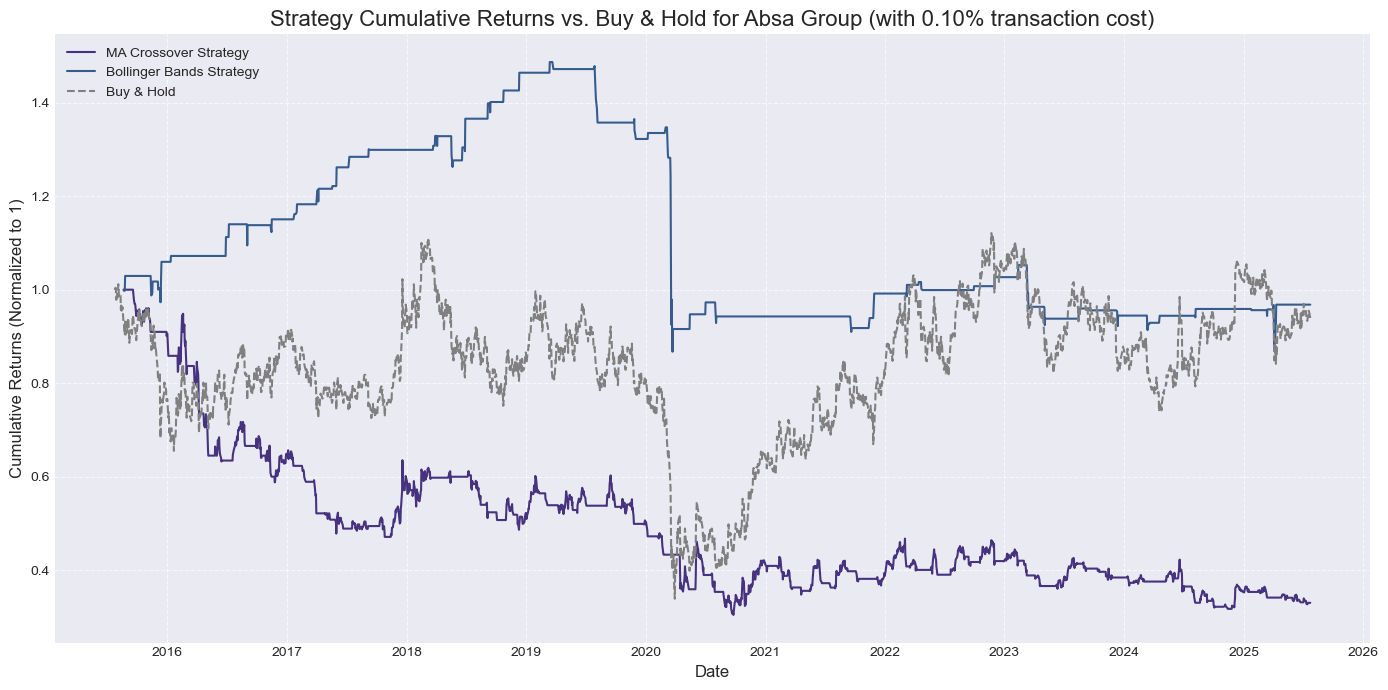

  > Plot for Absa Group generated.

5.1 Processing backtests and generating plots for Capitec...
  > Running MA Crossover for Capitec...
  > Running Bollinger Bands for Capitec...
  > Generating cumulative returns plot for Capitec...


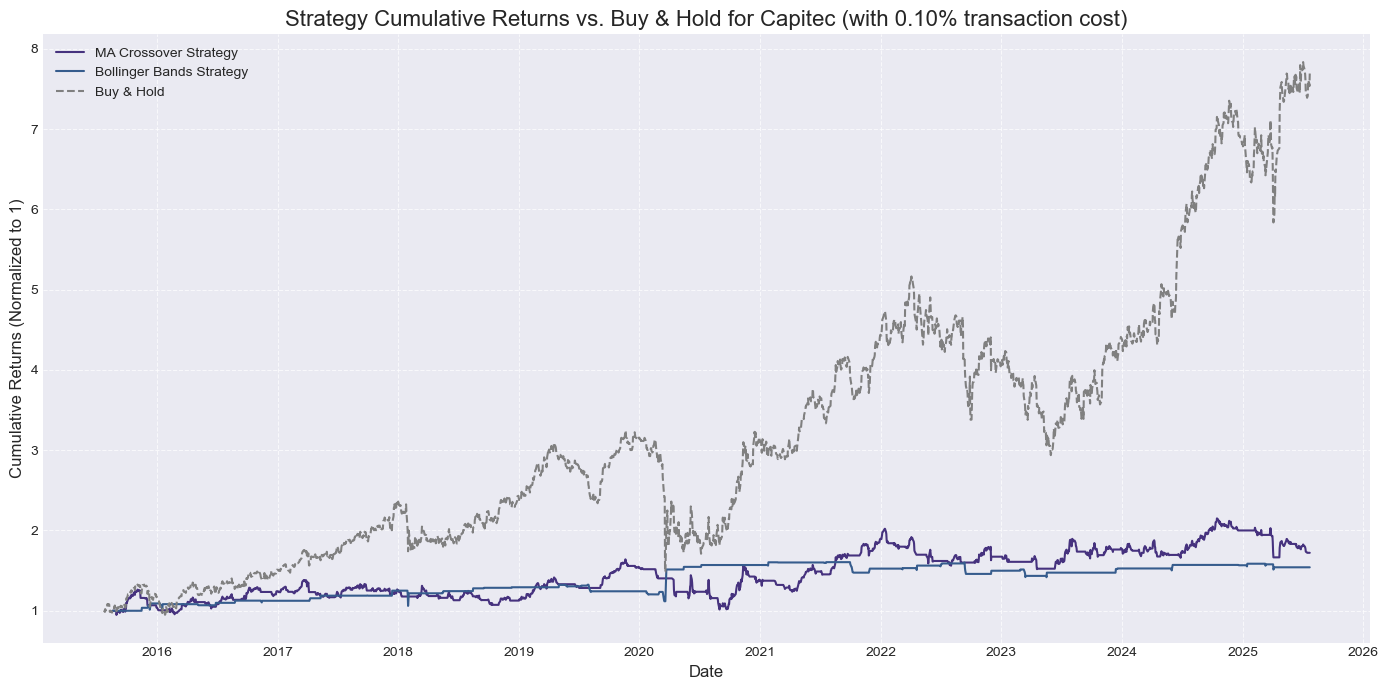

  > Plot for Capitec generated.

5.1 Processing backtests and generating plots for FirstRand...
  > Running MA Crossover for FirstRand...
  > Running Bollinger Bands for FirstRand...
  > Generating cumulative returns plot for FirstRand...


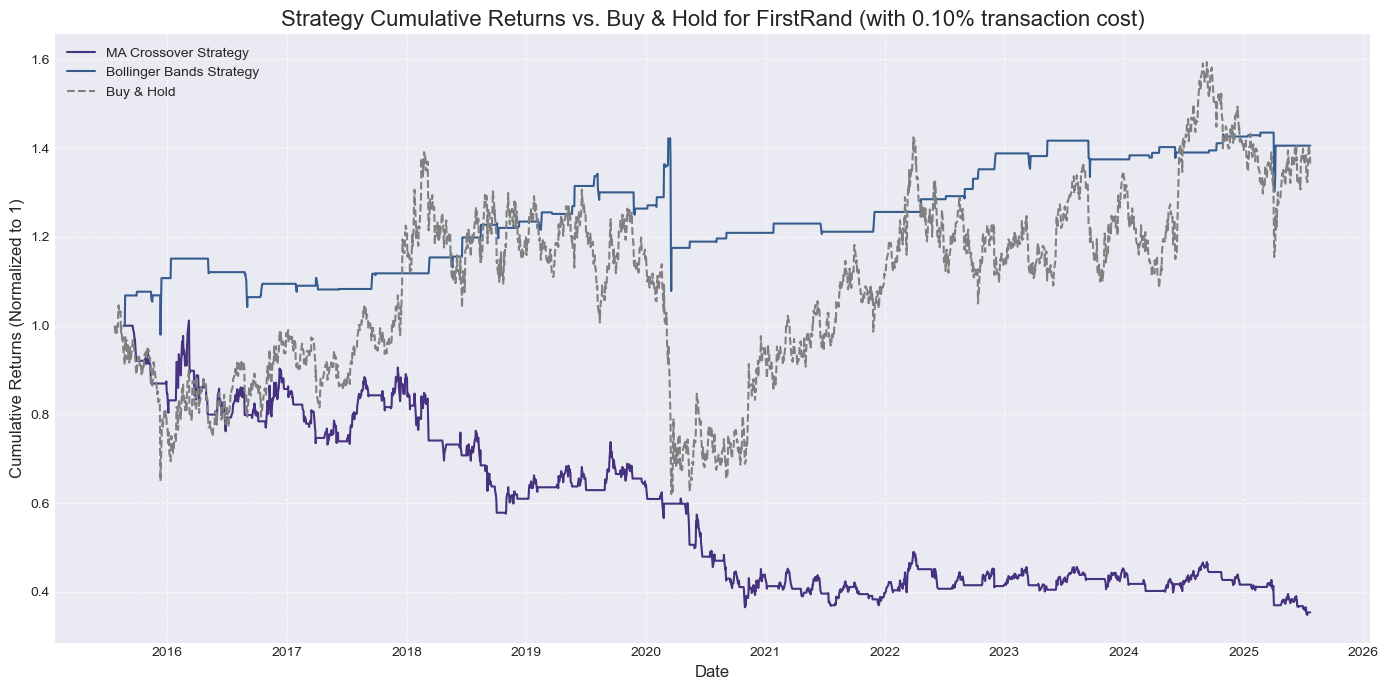

  > Plot for FirstRand generated.

5.1 Processing backtests and generating plots for Nedbank...
  > Running MA Crossover for Nedbank...
  > Running Bollinger Bands for Nedbank...
  > Generating cumulative returns plot for Nedbank...


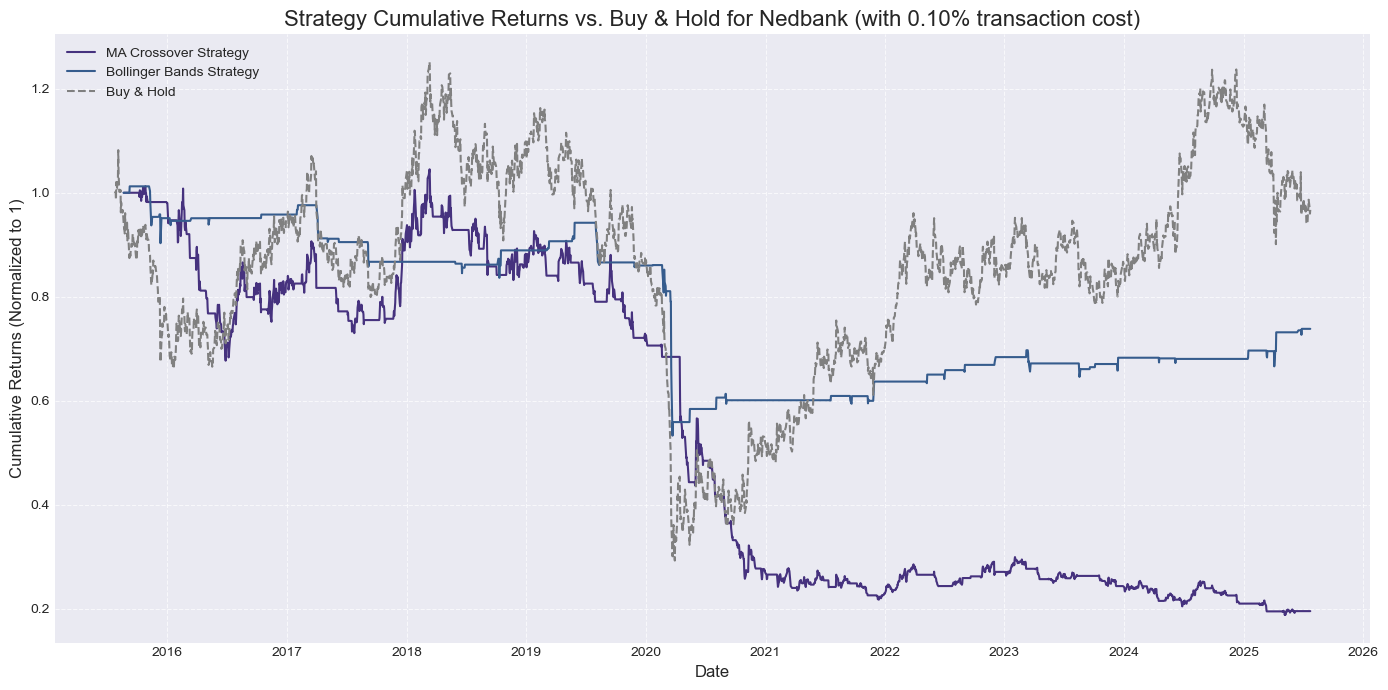

  > Plot for Nedbank generated.

5.1 Processing backtests and generating plots for Standard Bank...
  > Running MA Crossover for Standard Bank...
  > Running Bollinger Bands for Standard Bank...
  > Generating cumulative returns plot for Standard Bank...


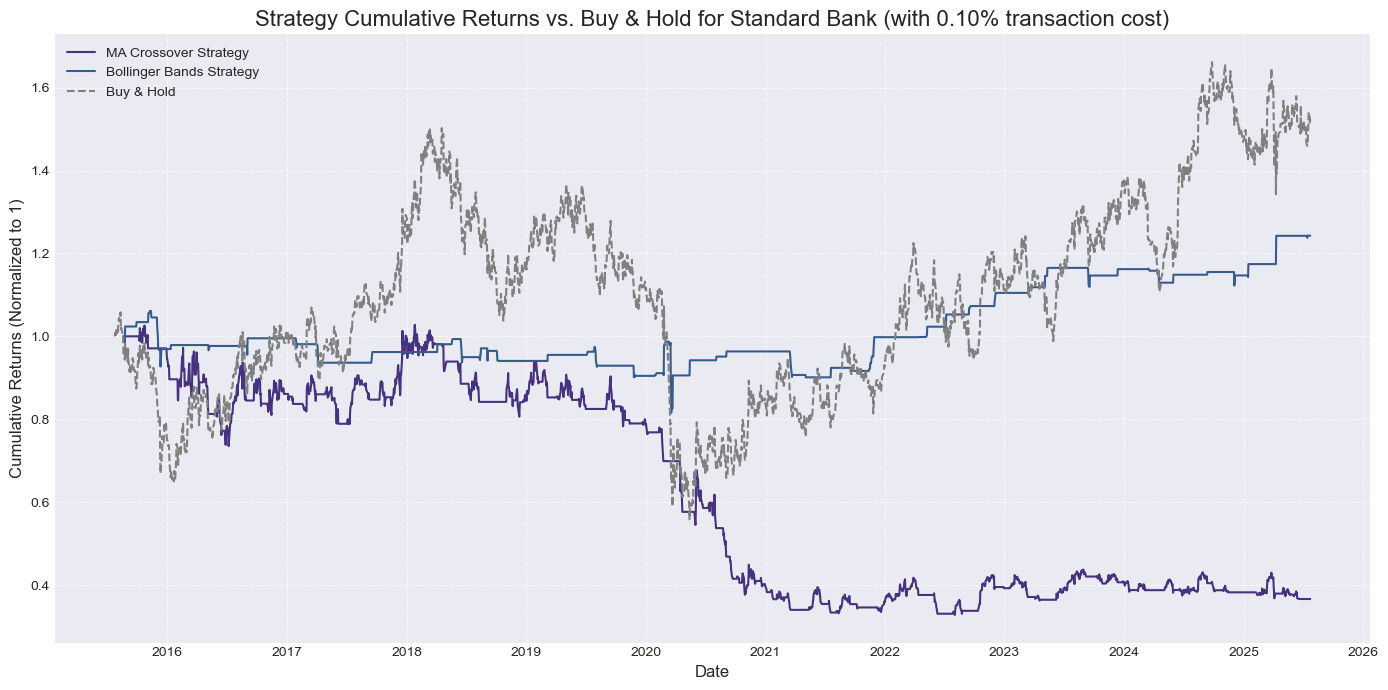

  > Plot for Standard Bank generated.

--- All strategy backtests and plots completed. ---
--- Section 5 Complete ---



In [13]:
# %% [code]
# --- Section 5: Strategy Backtesting & Visualizations ---

print("--- Section 5: Running Strategy Backtests for All Stocks ---")

# Initialize dictionaries to store performance metrics for each strategy across all stocks
ma_performance = {}
bb_performance = {}
buy_hold_performance = {}

# Loop through each stock in your cleaned data (using the human-readable names)
for stock_name in close_prices.columns:
    print(f"\n5.1 Processing backtests and generating plots for {stock_name}...")
    current_stock_prices = close_prices[stock_name]

    # --- 5.1.1 Calculate Buy & Hold Performance for the current stock (Benchmark) ---
    initial_price = current_stock_prices.iloc[0]
    final_price = current_stock_prices.iloc[-1]
    bh_total_return = (final_price / initial_price) - 1

    bh_annualized_return = (1 + bh_total_return)**(252 / len(current_stock_prices)) - 1
    bh_daily_returns = current_stock_prices.pct_change().dropna()
    bh_annualized_vol = bh_daily_returns.std() * np.sqrt(252)
    bh_sharpe = (bh_annualized_return - RISK_FREE_RATE_ANNUAL) / bh_annualized_vol if bh_annualized_vol != 0 else np.nan

    buy_hold_performance[stock_name] = {
        'Total Return': bh_total_return,
        'Annualized Return': bh_annualized_return,
        'Sharpe Ratio': bh_sharpe
    }

    # --- 5.1.2 Run MA Crossover Strategy Backtest ---
    print(f"  > Running MA Crossover for {stock_name}...")
    ma_strategy_df = backtest_ma_crossover(current_stock_prices, MA_SHORT_WINDOW, MA_LONG_WINDOW)
    ma_metrics = calculate_strategy_performance(ma_strategy_df, TRANSACTION_COST)
    ma_performance[stock_name] = ma_metrics
    # Add cumulative returns for plotting
    ma_strategy_df['Cumulative_Returns'] = (1 + ma_strategy_df['Strategy_Return']).cumprod()


    # --- 5.1.3 Run Bollinger Bands Strategy Backtest ---
    print(f"  > Running Bollinger Bands for {stock_name}...")
    bb_strategy_df = backtest_bollinger_bands(current_stock_prices, BB_WINDOW, BB_NUM_STD_DEV)
    bb_metrics = calculate_strategy_performance(bb_strategy_df, TRANSACTION_COST)
    bb_performance[stock_name] = bb_metrics
    # Add cumulative returns for plotting
    bb_strategy_df['Cumulative_Returns'] = (1 + bb_strategy_df['Strategy_Return']).cumprod()

    # --- 5.1.4 Generate and Display Cumulative Returns Plot for the current stock ---
    print(f"  > Generating cumulative returns plot for {stock_name}...")
    plot_cumulative_returns(
        {
            'MA Crossover Strategy': ma_strategy_df,
            'Bollinger Bands Strategy': bb_strategy_df,
            'Close': current_stock_prices.to_frame(name='Close') # Pass original prices for Buy & Hold benchmark
        },
        title=f'Strategy Cumulative Returns vs. Buy & Hold for {stock_name}',
        transaction_costs_value=TRANSACTION_COST # Display transaction costs in plot title
    )
    print(f"  > Plot for {stock_name} generated.")

print("\n--- All strategy backtests and plots completed. ---")
print("--- Section 5 Complete ---\n")

<div style="
    border-left: 4px solid #4CAF50;
    background: #e8f5e9;
    padding: 16px;
    margin: 20px 0;
    border-radius: 6px;
">
  <h3 style="margin:0; color:#4CAF50;">📈 Results: Individual Strategy Performance</h3>
  <p style="margin:12px 0 0 0; text-align: justify;">
    The series of plots above visually represents the cumulative performance of the Moving Average Crossover and Bollinger Bands strategies against a simple Buy & Hold benchmark for each JSE bank stock. Key observations from these plots include:<br><br>
    <ul>
        <li><b>Buy & Hold as Baseline:</b> For most banks (Absa, FirstRand, Nedbank, Standard Bank), the Buy & Hold strategy delivered moderate to negative returns over the 10-year period. Capitec, however, showed significant growth, outperforming all other banks and strategies for Buy & Hold.</li>
        <li><b>MA Crossover Underperformance:</b> Across almost all stocks, the Moving Average Crossover strategy consistently underperformed Buy & Hold. Its equity curve often shows whipsaws and declining performance, suggesting that in these market conditions and with the chosen parameters, it generated frequent losing trades, especially once transaction costs are considered.</li>
        <li><b>Bollinger Bands Mixed Performance:</b> The Bollinger Bands strategy showed more varied results. While it sometimes reduced volatility or drew down less than MA Crossover, it still struggled to consistently outperform Buy & Hold for many stocks after transaction costs. For Capitec, it achieved positive absolute returns, but still less than Buy & Hold.</li>
        <li><b>Impact of Transaction Costs Visually:</b> The "with 0.10% transaction cost" label on the plots highlights how even a small cost per trade can significantly dampen a strategy's net performance, making otherwise theoretically profitable strategies unprofitable in practice.</li>
    </ul>
    These individual plots set the stage for our final consolidated performance comparison, which will quantify these visual insights.
  </p>
</div>

<div style="
    border-left: 4px solid #009688;
    background: #e0f1f1;
    padding: 16px;
    margin: 20px 0;
    border-radius: 6px;
">
  <h3 style="margin:0; color:#009688;">📊 6. Final Performance Summaries</h3>
  <p style="margin:12px 0 0 0; text-align: justify;">
    After running individual backtests and visualizing their performance, this section consolidates all the results into **clear, comparative tables**.
    <br>You'll find detailed performance metrics (including total return, annualized return, volatility, Sharpe ratio, and maximum drawdown) for:
    <br>• The **Moving Average Crossover Strategy**
    <br>• The **Bollinger Bands Strategy**
    <br>• The **Buy & Hold Benchmark**
    <br>These tables offer a comprehensive overview, allowing for a direct comparison of strategy effectiveness and overall stock performance across the entire analysis period, with transaction costs fully integrated.
  </p>
</div>

In [62]:
from IPython.display import display, Markdown

# %% [code]
# --- Section 6: Final Performance Summaries ---

# Convert the dictionaries of performance metrics (populated in Cell 6) into pandas DataFrames.
# .T (transpose) is used to make stock names the rows, which is typically easier to read for comparisons.
ma_results_df = pd.DataFrame(ma_performance).T
bb_results_df = pd.DataFrame(bb_performance).T
buy_hold_results_df = pd.DataFrame(buy_hold_performance).T

# Display the Moving Average Crossover Strategy Performance
display(Markdown("\n### 6.1 Moving Average Crossover Strategy Performance (with Transaction Costs) ###"))
display(ma_results_df)
display(Markdown("\n*Interpretation: Note the impact of transaction costs on profitability. Negative Sharpe ratios indicate returns did not justify the risk taken.*"))

# Display the Bollinger Bands Strategy Performance
display(Markdown("\n### 6.2 Bollinger Bands Strategy Performance (with Transaction Costs) ###"))
display(bb_results_df)
display(Markdown("\n*Interpretation: Often performed better than MA Crossover, but still heavily impacted by transaction costs for most stocks.*"))

# Display the Buy & Hold Performance (Benchmark)
display(Markdown("\n### 6.3 Buy & Hold Performance (Benchmark) ###"))
display(buy_hold_results_df)
display(Markdown("\n*Interpretation: This is the baseline performance without any active trading strategy. Capitec stands out with significantly higher returns.*"))

print("\n--- Consolidated performance summaries displayed. ---")


### 6.1 Moving Average Crossover Strategy Performance (with Transaction Costs) ###

,Total Return,Net Total Return (with costs),Annualized Return (Net),Annualized Volatility (Net),"Sharpe Ratio (Net, Annualized)",Max Drawdown
Absa Group,-0.669762,-0.747762,-0.129633,0.232711,-0.857858,-0.695715
Capitec,0.722096,0.654096,0.052037,0.203295,-0.088360,-0.380819
FirstRand,-0.646218,-0.726218,-0.122413,0.216750,-0.887718,-0.655945
Nedbank,-0.804285,-0.886285,-0.196795,0.227464,-1.172912,-0.819737
Standard Bank,-0.633653,-0.710653,-0.117508,0.212688,-0.881608,-0.680997



*Interpretation: Note the impact of transaction costs on profitability. Negative Sharpe ratios indicate returns did not justify the risk taken.*


### 6.2 Bollinger Bands Strategy Performance (with Transaction Costs) ###

,Total Return,Net Total Return (with costs),Annualized Return (Net),Annualized Volatility (Net),"Sharpe Ratio (Net, Annualized)",Max Drawdown
Absa Group,-0.032021,-0.095021,-0.010010,0.110451,-0.724393,-0.416701
Capitec,0.541438,0.484438,0.040607,0.142512,-0.206253,-0.155561
FirstRand,0.405833,0.339833,0.029915,0.102191,-0.392252,-0.241950
Nedbank,-0.261618,-0.324618,-0.038774,0.103381,-1.052163,-0.473431
Standard Bank,0.242931,0.180931,0.016898,0.085585,-0.620462,-0.231546



*Interpretation: Often performed better than MA Crossover, but still heavily impacted by transaction costs for most stocks.*


### 6.3 Buy & Hold Performance (Benchmark) ###

,Total Return,Annualized Return,Sharpe Ratio
Absa Group,-0.057697,-0.005925,-0.218477
Capitec,6.691327,0.226310,0.445341
FirstRand,0.365442,0.031638,-0.117809
Nedbank,-0.032919,-0.003342,-0.212890
Standard Bank,0.523315,0.042987,-0.084372



*Interpretation: This is the baseline performance without any active trading strategy. Capitec stands out with significantly higher returns.*


--- Consolidated performance summaries displayed. ---


In [ ]:
# %% [code]
# --- 4. Export Results ---

print("\n--- Exporting results to CSV files ---")

try:
    # Export the Moving Average Crossover strategy performance
    ma_results_df.to_csv('ma_crossover_performance.csv', index=True)
    print("  'ma_crossover_performance.csv' exported successfully.")

    # Export the Bollinger Bands strategy performance
    bb_results_df.to_csv('bollinger_bands_performance.csv', index=True)
    print("  'bollinger_bands_performance.csv' exported successfully.")

    # Export the risk metrics summary (VaR, CVaR, Sharpe Ratios)
    var_cvar_df.to_csv('risk_metrics_summary.csv', index=True)
    print("  'risk_metrics_summary.csv' exported successfully.")

    # Export the Buy & Hold performance
    buy_hold_results_df.to_csv('buy_hold_performance.csv', index=True)
    print("  'buy_hold_performance.csv' exported successfully.")

except Exception as e:
    print(f"Error exporting files: {e}")
    print("Please ensure you have write permissions to the current directory.")

print("\nAll major results have been exported.")

<div style="
    border-left: 4px solid #4CAF50;
    background: #e8f5e9;
    padding: 16px;
    margin: 20px 0;
    border-radius: 6px;
">
  <h3 style="margin:0; color:#4CAF50;">📈 Results: Consolidated Strategy Performance Insights</h3>
  <p style="margin:12px 0 0 0; text-align: justify;">
    The tables directly above provide a comprehensive overview of how each strategy and the Buy & Hold benchmark performed across all JSE bank stocks, with transaction costs (0.10% per round-trip) included.<br><br>
    <ul>
        <li><b>Moving Average Crossover:</b> This strategy consistently yielded **negative net total returns and very poor (highly negative) Sharpe Ratios** for most banks. This strongly suggests it's not a suitable strategy for these assets under the given market conditions and parameters, with transaction costs significantly eroding any potential gains.</li>
        <li><b>Bollinger Bands Strategy:</b> While performing generally better than the MA Crossover, the Bollinger Bands strategy also struggled to achieve positive risk-adjusted returns after transaction costs for many stocks. Capitec showed positive absolute returns with this strategy, but still a negative Sharpe Ratio, indicating that even its performance didn't sufficiently cover the risk and costs.</li>
        <li><b>Buy & Hold (Benchmark):</b> Capitec stands out as the clear winner under a simple Buy & Hold strategy, achieving substantial total and annualized returns with a positive Sharpe Ratio. The other banks generally delivered low or negative Sharpe Ratios for Buy & Hold, indicating that their raw returns did not adequately compensate for their volatility.</li>
        <li><b>Crucial Impact of Transaction Costs:</b> The negative net total returns and Sharpe Ratios for most active strategies vividly demonstrate how even a small transaction cost can decimate profitability, emphasizing the need for highly efficient and robust strategies to overcome trading expenses.</li>
    </ul>
  </p>
</div>